### Ejecución Random Forest PM25

Librerias

In [190]:
import numpy as np
import pandas as pd
import joblib

#Librerias del modelo

from sklearn.ensemble import RandomForestRegressor
#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
#import statsmodels.api as sm
import math
#evaluacion de variables
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import joblib

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Se importa nuestro DataSet Limpio a partir de la limpieza de datos

In [191]:
dataSetCalidadAire = pd.read_csv("data/stage/dataSetLimpio4.csv")

dataSetCalidadAire.head(3)

,anio,mes,dia,hora,pm25,festivo,temperatura,humedad,presion,p1,...,dia_semana_Inicio Semana,dia_semana_Media semana,estacion_Estacion Aranjuez,estacion_Estacion Belen,estacion_Estacion Caldas,estacion_Estacion Itagui,franja_horaria_Madrugada,franja_horaria_Mañana,franja_horaria_Noche,franja_horaria_Tarde
0,2024,1,1,0,16,1,20,84,0,0,...,1,0,0,0,0,1,1,0,0,0
1,2024,1,1,2,47,1,18,82,0,0,...,1,0,0,0,0,1,1,0,0,0
2,2024,1,1,6,39,1,17,84,0,0,...,1,0,0,0,0,1,0,1,0,0


Se divide nuestra variable objetivo para que quede en Y y X las columnas

In [192]:
columnasEliminar = ['pm25']
X = dataSetCalidadAire.drop(columns = columnasEliminar)
y = dataSetCalidadAire['pm25']

División de los datos 70% Entrenamiento 30% Testeo

In [193]:
# División de los datos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7, #70 % de nuestros datos en entrenamiento
    random_state=1234,
    shuffle=True
)

Uso del Scaler para nuestro X_test X_train

In [194]:
columnasModelo = X.columns.tolist()
columnasModelo 
# Llamamos nuestro scaler ya guardado
scaler = joblib.load("data/stage/estandarizacionDataSet4.pkl")
# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[columnasModelo] = scaler.fit_transform(X_train[columnasModelo])
X_test[columnasModelo] = scaler.transform(X_test[columnasModelo])

X_train[columnasModelo].head(3)

,anio,mes,dia,hora,festivo,temperatura,humedad,presion,p1,velocidad_prom,...,dia_semana_Inicio Semana,dia_semana_Media semana,estacion_Estacion Aranjuez,estacion_Estacion Belen,estacion_Estacion Caldas,estacion_Estacion Itagui,franja_horaria_Madrugada,franja_horaria_Mañana,franja_horaria_Noche,franja_horaria_Tarde
10479,0.0000,0.0000,0.8333,0.2609,0.0000,0.3182,0.7209,0.9953,0.0000,0.0000,...,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
18821,0.0000,0.8750,0.2667,0.9130,0.0000,0.4545,0.6860,0.9953,0.0000,0.0000,...,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
14028,0.0000,0.7500,0.2667,0.3913,0.0000,0.5455,0.5000,0.9953,0.0000,0.2000,...,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


### Creación del modelo inicial

In [195]:
# Creación del modelo
# ==============================================================================
modelRF = RandomForestRegressor(
            n_estimators = 25, #Con tanteo se escogio esta cantidad de árboles
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,   #out-of-bag samples
            n_jobs       = -1,
            random_state = 123
         )


# Entrenamiento del modelo
# ==============================================================================
modelRF.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=25, n_jobs=-1,
                      random_state=123)

### Evaluación del modelo Inicial

Error cuadrático Medio y el coficiente de determinación con respecto a las variables de testeo

In [196]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 6.917887547755696
El error (r2) de test es: 0.5385454432879192


Error cuadrático Medio y el coficiente de determinación con respecto a las variables de train

In [197]:
# Error de train del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_train)

rmse = mean_squared_error(y_true  = y_train, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train, predicciones)
print(f"El error (r2) de train es: {r2}")

El error (rmse) de train es: 2.75381646856164
El error (r2) de train es: 0.9261477209846938


In [198]:
len(dataSetCalidadAire)

19447

### Proceso para encontrar los hiperparametros  

Escalamos todo nuestro dataset para nuestro X_Completo

In [199]:
X_Completo = X
y_Completo = y

# Se escalan los datos numéricos de entrada
X_Completo[columnasModelo] = scaler.fit_transform(X_Completo[columnasModelo])

Estimar la cantidad de árboles mediante el Out of Bag Error

Valor óptimo de n_estimators(árboles): 35


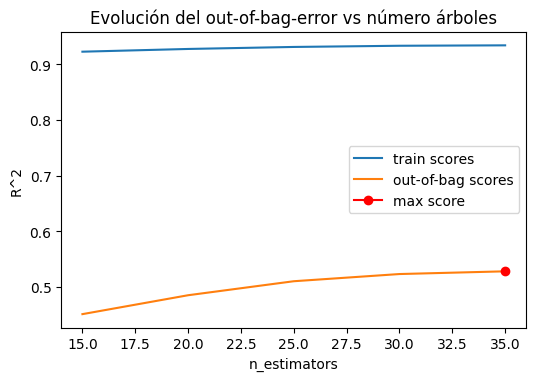

In [200]:
train_scores = []
oob_scores   = []

# se deja un rango de posibles cantidades de árboles para el modelo se dejo entre 15 a 40
estimator_range = range(15, 40, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #Squared error
                max_depth    = None, #No dejamos profundidad
                max_features = 'sqrt',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    


# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend()
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Estimar la cantidad de árboles mediante validación cruzada

Valor óptimo de n_estimators: 35


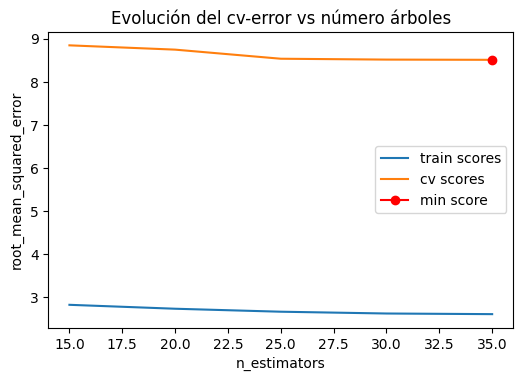

In [201]:
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(15, 40, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #quared error
                max_depth    = None, #Sin profundidad
                max_features = 'sqrt',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 3 #Dejamos 3 pliegues
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend()
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Estimar la cantidad de carácterísticas mediante el Out of Bag Error

Valor óptimo de max_features: 21


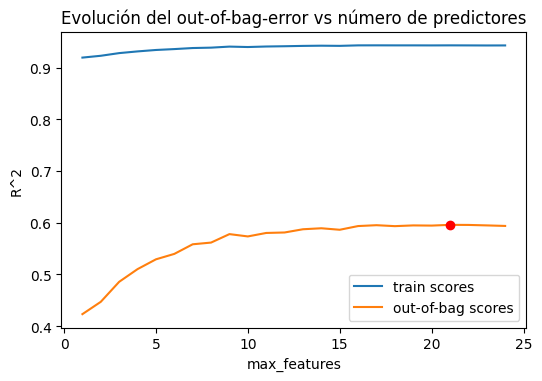

In [202]:
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1) #X_train.shape[1] = total de características


# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 25,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend()
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Estimar la cantidad de carácterísticas mediante validación Cruzada

Valor óptimo de max_features: 15


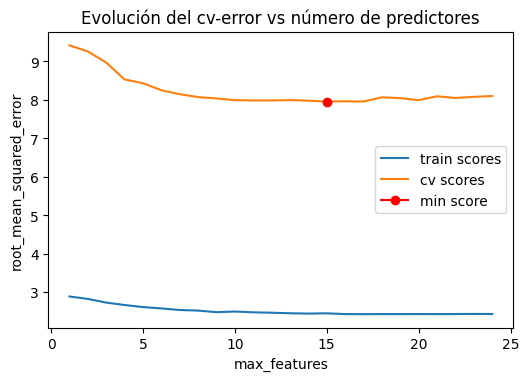

In [203]:
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = 25,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 3
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend()
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Ajustar los Hiperparámetros de acuerdoa  estas validaciones

In [204]:
# Grid de hiperparámetros evaluados
param_grid = ParameterGrid(
                {'n_estimators': [15,20,25],
                 'max_features': [6,8,10,12,14],
                 'max_depth'   : [4,8,15]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelRF = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelRF.fit(X_Completo, y_Completo)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelRF.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 4, 'max_features': 6, 'n_estimators': 15} ✓
Modelo: {'max_depth': 4, 'max_features': 6, 'n_estimators': 20} ✓
Modelo: {'max_depth': 4, 'max_features': 6, 'n_estimators': 25} ✓
Modelo: {'max_depth': 4, 'max_features': 8, 'n_estimators': 15} ✓
Modelo: {'max_depth': 4, 'max_features': 8, 'n_estimators': 20} ✓
Modelo: {'max_depth': 4, 'max_features': 8, 'n_estimators': 25} ✓
Modelo: {'max_depth': 4, 'max_features': 10, 'n_estimators': 15} ✓
Modelo: {'max_depth': 4, 'max_features': 10, 'n_estimators': 20} ✓
Modelo: {'max_depth': 4, 'max_features': 10, 'n_estimators': 25} ✓
Modelo: {'max_depth': 4, 'max_features': 12, 'n_estimators': 15} ✓
Modelo: {'max_depth': 4, 'max_features': 12, 'n_estimators': 20} ✓
Modelo: {'max_depth': 4, 'max_features': 12, 'n_estimators': 25} ✓
Modelo: {'max_depth': 4, 'max_features': 14, 'n_estimators': 15} ✓
Modelo: {'max_depth': 4, 'max_features': 14, 'n_estimators': 20} ✓
Modelo: {'max_depth': 4, 'max_features': 14, 'n_estimators': 25} ✓
M

,oob_r2,max_depth,max_features,n_estimators
44,0.5961,15,14,25
41,0.5896,15,12,25
43,0.5841,15,14,20
38,0.5790,15,10,25
40,0.5757,15,12,20


In [205]:
# Mejores hiperparámetros por out-of-bag error
print("Mejores hiperparámetros encontrados (oob-r2)")
print(f"mejor hiperparametros: {resultados.head(1)}")
print(resultados.iloc[0,:]['oob_r2'], "R2")

Mejores hiperparámetros encontrados (oob-r2)
mejor hiperparametros:     oob_r2  max_depth  max_features  n_estimators
44  0.5961         15            14            25
0.5960559722942557 R2


Se realiza la busqueda de los mejores hiperparametros con GridSearch

In [206]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor
modelRF = RandomForestRegressor(random_state = 123)
CV = 10
parameters =    {'n_estimators': [15,20,25],
                 'max_features': [6,8,10,12,14],
                 'max_depth'   : [4,8,15]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'r2',      
                    n_jobs     = - 1,
                    cv         = CV, 
                    refit      = True,
                    verbose    = 3,
                    return_train_score = True
                   )

grid_RF.fit(X = X_Completo, y = y_Completo)


Fitting 10 folds for each of 45 candidates, totalling 450 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [4, 8, 15],
                         'max_features': [6, 8, 10, 12, 14],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='r2', verbose=3)

In [207]:
# Resultados
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
44,15,14,25,0.3639,0.1675,0.8780,0.0069
38,15,10,25,0.3631,0.1502,0.8688,0.0066
41,15,12,25,0.3581,0.1642,0.8754,0.0071
37,15,10,20,0.3576,0.1517,0.8656,0.0067


In [208]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_RF = pd.DataFrame(grid_RF.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_RF = ['param_max_depth']  + \
                    ['param_max_features']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_RF_filtered = results_grid_RF[columns_grid_RF]

# Crear la columna scoreWithStd: f1 / std
results_grid_RF_filtered['scoreWithStd'] = results_grid_RF_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_RF_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_RF_filtered[['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']].head(4)


,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,4,6,15,0.1631,0.0953,1.7118
1,4,6,20,0.1687,0.0952,1.7717
2,4,6,25,0.1745,0.0941,1.8538
3,4,8,15,0.1980,0.0906,2.1854


In [209]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Mejores Parámetros : ',best_params)

Mejores Parámetros :  {'max_depth': 15, 'max_features': 14, 'n_estimators': 25}


In [210]:
# Top 3 de los mejores scores
results_grid_RF_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
17,8,6,25,0.2939,0.0997,2.9489
16,8,6,20,0.2945,0.1003,2.9375
15,8,6,15,0.2871,0.1029,2.7904


In [211]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_RF_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth       8.0000
param_max_features    6.0000
param_n_estimators   25.0000
mean_test_score       0.2939
std_test_score        0.0997
split0_test_score     0.2845
split1_test_score     0.1232
split2_test_score     0.1944
split3_test_score     0.4437
split4_test_score     0.2547
split5_test_score     0.4076
split6_test_score     0.3533
split7_test_score     0.2619
split8_test_score     0.4035
split9_test_score     0.2117
scoreWithStd          2.9489
Name: 17, dtype: float64

In [212]:
results_grid_RF_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

np.float64(0.29385657730413545)

Parte Final para creación del Modelo con los mejores Hiperparametros

In [213]:
columnasEliminar = ['pm25']
X = dataSetCalidadAire.drop(columns = columnasEliminar)
y = dataSetCalidadAire['pm25']

In [214]:
# División de los datos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7, #70 % de nuestros datos en entrenamiento
    random_state=1234,
    shuffle=True
)

Se corrobora la cantidad de datos

In [215]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

13612
5835
13612
5835


In [216]:
# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
columnasModelo = X.columns.tolist()
columnasModelo 
X_train[columnasModelo] = scaler.fit_transform(X_train[columnasModelo])
X_test[columnasModelo] = scaler.transform(X_test[columnasModelo])

X_train[columnasModelo].head(3)

,anio,mes,dia,hora,festivo,temperatura,humedad,presion,p1,velocidad_prom,...,dia_semana_Inicio Semana,dia_semana_Media semana,estacion_Estacion Aranjuez,estacion_Estacion Belen,estacion_Estacion Caldas,estacion_Estacion Itagui,franja_horaria_Madrugada,franja_horaria_Mañana,franja_horaria_Noche,franja_horaria_Tarde
10479,0.0000,0.0000,0.8333,0.2609,0.0000,0.3182,0.7209,0.9953,0.0000,0.0000,...,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
18821,0.0000,0.8750,0.2667,0.9130,0.0000,0.4545,0.6860,0.9953,0.0000,0.0000,...,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
14028,0.0000,0.7500,0.2667,0.3913,0.0000,0.5455,0.5000,0.9953,0.0000,0.2000,...,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


Se desarrolla modelo Final

In [217]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros 
modeloFinalRF = RandomForestRegressor( max_depth = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_depth"])
                               , max_features = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_features"])
                               , n_estimators = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_n_estimators"])
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modeloFinalRF.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=6, n_estimators=25,
                      random_state=1234)

Error cuadrático Medio y el coficiente de determinación con respecto a las variables de testeo

In [218]:
# Error de test del modelo Final 

predicciones = modeloFinalRF.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 7.510020074404275
El error (r2) de test es: 0.45616877677036305


Error cuadrático Medio y el coficiente de determinación con respecto a las variables de train

In [219]:
#Error de train del modelo Final
predicciones = modeloFinalRF.predict(X = X_train)

rmse = mean_squared_error(y_true  = y_train, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train, predicciones)
print(f"El error (r2) de train es: {r2}")



El error (rmse) de train es: 7.1645272307182415
El error (r2) de train es: 0.5001162817707341


In [220]:
importancia_predictores = pd.DataFrame(
                            {'predictor': dataSetCalidadAire.drop(columns = columnasEliminar).columns,
                             'importancia': modeloFinalRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo\n")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo



,predictor,importancia
1,mes,0.3864
21,franja_horaria_Mañana,0.0965
2,dia,0.0835
6,humedad,0.0785
3,hora,0.0772
5,temperatura,0.0497
23,franja_horaria_Tarde,0.0381
11,direccion_prom,0.0354
12,direccion_max,0.0318
7,presion,0.0262


### Guardar el modelo final

In [221]:
joblib.dump(modeloFinalRF, 'data/analytics/modelosPM25/modeloRandomForestPM25.pkl')

['data/analytics/modelosPM25/modeloRandomForestPM25.pkl']